In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time 

df = pd.read_pickle('data/pkl/PreciosBlue.xlsx.pkl')
df

,Fecha,Compra,Venta
0,2023-01-27,381.00,385.00
1,2023-01-26,379.00,383.00
2,2023-01-25,377.00,381.00
3,2023-01-24,372.00,376.00
4,2023-01-23,372.00,376.00
...,...,...,...
3214,2010-01-07,3.86,3.87
3215,2010-01-06,3.87,3.88
3216,2010-01-05,3.86,3.86
3217,2010-01-04,3.86,3.86


In [2]:
# renaming for fbprophet
df.rename(columns={'Fecha':'ds'}, inplace=True)
df.rename(columns={'Venta':'y'}, inplace=True)
df.reset_index(inplace=True)
df.head()

,index,ds,Compra,y
0,0,2023-01-27,381.0,385.0
1,1,2023-01-26,379.0,383.0
2,2,2023-01-25,377.0,381.0
3,3,2023-01-24,372.0,376.0
4,4,2023-01-23,372.0,376.0


In [3]:
df.rename(columns={'Fecha':'ds'}, inplace=True)

In [4]:
df = df[df['ds'] >= '2018-01-01']

df

,index,ds,Compra,y
0,0,2023-01-27,381.00,385.00
1,1,2023-01-26,379.00,383.00
2,2,2023-01-25,377.00,381.00
3,3,2023-01-24,372.00,376.00
4,4,2023-01-23,372.00,376.00
...,...,...,...,...
1268,1268,2018-01-05,19.05,19.45
1269,1269,2018-01-04,19.01,19.41
1270,1270,2018-01-03,18.89,19.29
1271,1271,2018-01-02,18.85,19.25


In [5]:
df.drop(['Compra'], axis=1)

,index,ds,y
0,0,2023-01-27,385.00
1,1,2023-01-26,383.00
2,2,2023-01-25,381.00
3,3,2023-01-24,376.00
4,4,2023-01-23,376.00
...,...,...,...
1268,1268,2018-01-05,19.45
1269,1269,2018-01-04,19.41
1270,1270,2018-01-03,19.29
1271,1271,2018-01-02,19.25


In [6]:
df = df.sort_values(by='ds')

In [38]:
df

,index,ds,Compra,y
536,536,2021-01-04,159.0,165.0
535,535,2021-01-05,154.0,160.0
534,534,2021-01-06,154.0,160.0
533,533,2021-01-07,156.0,162.0
532,532,2021-01-08,155.0,161.0
...,...,...,...,...
3,3,2023-01-24,372.0,376.0
2,2,2023-01-25,377.0,381.0
1,1,2023-01-26,379.0,383.0
0,0,2023-01-27,381.0,385.0


In [7]:
df['y'].round(2).describe()

count    1273.000000
mean      131.245020
std        90.371127
min        19.250000
25%        43.800000
50%       132.000000
75%       195.000000
max       387.000000
Name: y, dtype: float64

In [8]:
from prophet import Prophet

prophet_model = Prophet()
prophet_model.fit(df)

c:\Users\rodri\anaconda3.1\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
22:07:40 - cmdstanpy - INFO - Chain [1] start processing
22:07:45 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
future_dataset= prophet_model.make_future_dataframe(periods=1, freq='y') # Data para el proximo año
future_dataset.tail()

,ds
1235,2023-01-25
1236,2023-01-26
1237,2023-01-27
1238,2023-01-30
1239,2023-12-31


In [10]:
pred = prophet_model.predict(future_dataset)
pred[['ds','yhat', 'yhat_lower', 'yhat_upper']].head() # only useful columns

,ds,yhat,yhat_lower,yhat_upper
0,2018-01-02,26.885205,11.987958,39.155349
1,2018-01-03,27.905285,14.565081,41.746024
2,2018-01-04,28.163598,13.516992,41.612909
3,2018-01-05,28.467728,15.078773,41.684959
4,2018-01-08,28.615487,15.966410,43.003804


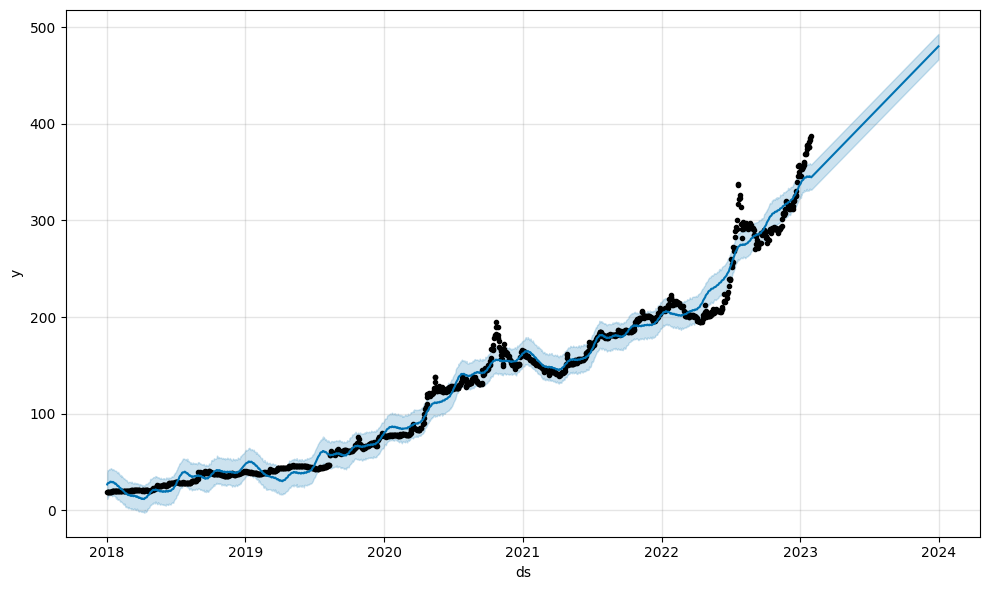

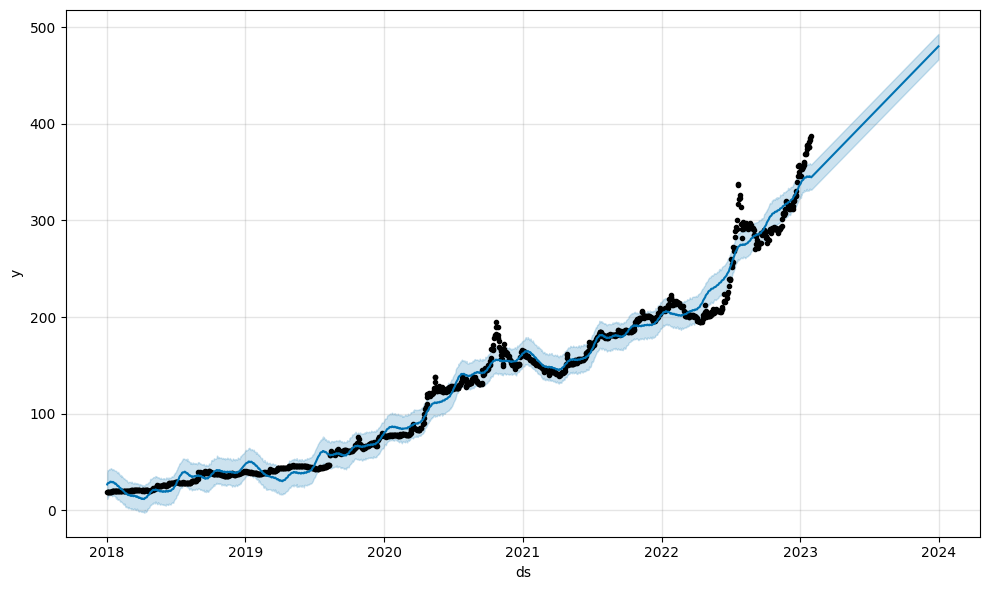

In [11]:
prophet_model.plot(pred)

In [12]:
def fb_prophet_function(data, future_years, seasonality_name, seasonality_val,seasonality_fourier, **params):
    """
    Trains a fb prophet model on given hyperparameters and custom
    seasonality, predicts on future dataset, plot the results and
    return the model.
    """
    start= time.time()
    prophet_model = Prophet(**params)
    
    prophet_model.add_seasonality(name=seasonality_name, period=seasonality_val, fourier_order=seasonality_fourier)
        
    prophet_model.fit(data)
    
    future_dataset = prophet_model.make_future_dataframe(periods=future_years, freq='y')
    
    pred = prophet_model.predict(future_dataset)
    
    prophet_model.plot(pred, figsize=(15,7));
    plt.ylim(-500, 3000)
    plt.title(f"fourier order{seasonality_fourier}, seasonality time {seasonality_name}")
    plt.show()
    
    end = time.time()
    print(f"Total Execution Time {end-start} seconds")
    return prophet_model

In [13]:
def plot_valid(validation_set, size, model):
    pred = model.predict(validation_set)
    temp = df[-size:].copy().reset_index()
    temp['pred']=pred['yhat']
    temp.set_index('ds')[['y', 'pred']].plot()
    plt.tight_layout();

22:08:01 - cmdstanpy - INFO - Chain [1] start processing
22:09:28 - cmdstanpy - INFO - Chain [1] done processing


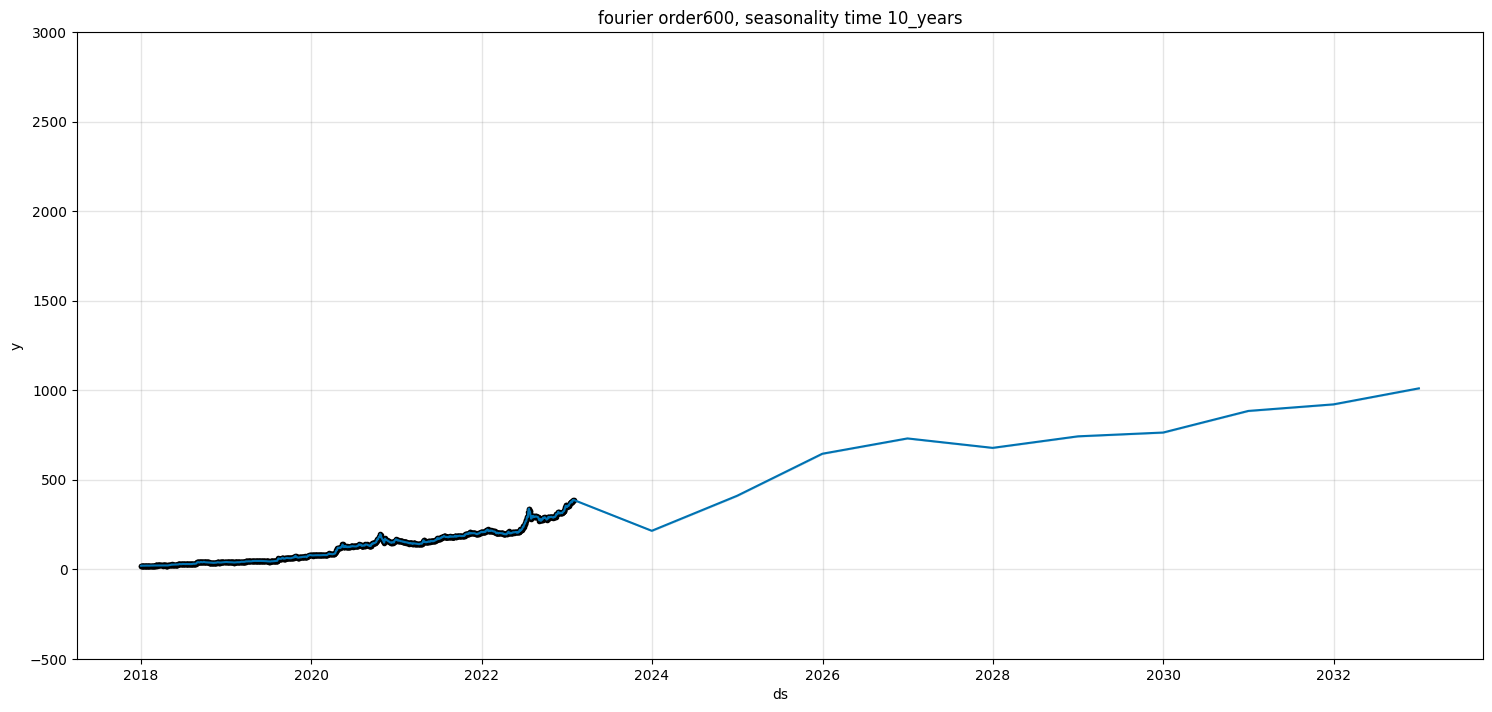

Total Execution Time 97.84224772453308 seconds


In [14]:
import time

training_set = df
validation_set = df 

ten_years = fb_prophet_function(data=training_set, future_years=10, seasonality_name='10_years', seasonality_val=365*10, seasonality_fourier=600,seasonality_mode='additive')

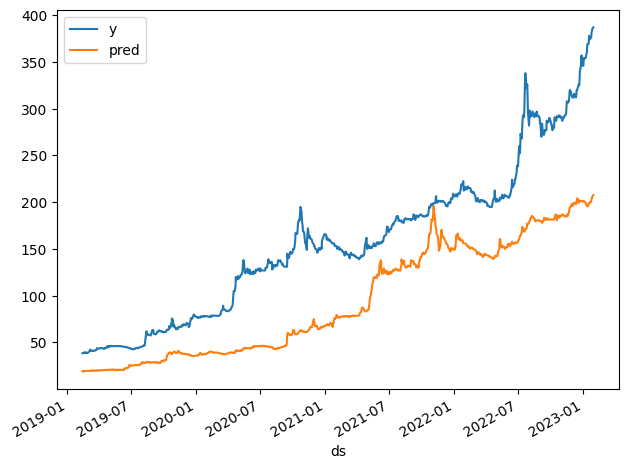

In [15]:
plot_valid(validation_set, 1000, ten_years)

In [16]:
pred = pred[['ds', 'yhat']]

pred

,ds,yhat
0,2018-01-02,26.885205
1,2018-01-03,27.905285
2,2018-01-04,28.163598
3,2018-01-05,28.467728
4,2018-01-08,28.615487
...,...,...
1235,2023-01-25,345.722427
1236,2023-01-26,345.565837
1237,2023-01-27,345.479492
1238,2023-01-30,344.635685


In [17]:
validation_set = validation_set[['ds', 'y']]

validation_set

,ds,y
1271,2018-01-02,19.25
1270,2018-01-03,19.29
1269,2018-01-04,19.41
1268,2018-01-05,19.45
1267,2018-01-08,19.58
...,...,...
3,2023-01-24,376.00
2,2023-01-25,381.00
1,2023-01-26,383.00
0,2023-01-27,385.00


In [18]:
pred = pred[pred['ds'].isin(validation_set['ds'])]

pred

,ds,yhat
0,2018-01-02,26.885205
1,2018-01-03,27.905285
2,2018-01-04,28.163598
3,2018-01-05,28.467728
4,2018-01-08,28.615487
...,...,...
1234,2023-01-24,345.137437
1235,2023-01-25,345.722427
1236,2023-01-26,345.565837
1237,2023-01-27,345.479492


In [19]:
merged1 = pd.merge(pred, validation_set, on='ds', how='inner')

validation_ds_y = merged1[['ds', 'y']]
pred_ds_yhat = merged1[['ds', 'yhat']]


In [20]:
validation_ds_y['ds'] = validation_ds_y['ds'].apply(lambda x: x.timestamp())
pred_ds_yhat['ds'] = pred_ds_yhat['ds'].apply(lambda x: x.timestamp())

C:\Users\rodri\AppData\Local\Temp\ipykernel_12876\2616818827.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_ds_y['ds'] = validation_ds_y['ds'].apply(lambda x: x.timestamp())
C:\Users\rodri\AppData\Local\Temp\ipykernel_12876\2616818827.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_ds_yhat['ds'] = pred_ds_yhat['ds'].apply(lambda x: x.timestamp())


In [21]:
validation_ds_y['ds'] = validation_ds_y['ds'].astype(float)
pred_ds_yhat['ds'] = pred_ds_yhat['ds'].astype(float)

C:\Users\rodri\AppData\Local\Temp\ipykernel_12876\476390056.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_ds_y['ds'] = validation_ds_y['ds'].astype(float)
C:\Users\rodri\AppData\Local\Temp\ipykernel_12876\476390056.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_ds_yhat['ds'] = pred_ds_yhat['ds'].astype(float)


In [22]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mae1 = mean_absolute_error(validation_ds_y, pred_ds_yhat)
mse1 = mean_squared_error(validation_ds_y, pred_ds_yhat)
rmse1 = math.sqrt(mean_squared_error(validation_ds_y, pred_ds_yhat))

print("Mean Absolute Error: ", mae1)
print("Mean Squared Error: ", mse1)
print("Root Mean Squared Error: ", rmse1)


Mean Absolute Error:  3.83879689744306
Mean Squared Error:  55.936902322416394
Root Mean Squared Error:  7.479097694402474


In [23]:
df = df[df['ds'] >= '2021-01-01']

df

,index,ds,Compra,y
536,536,2021-01-04,159.0,165.0
535,535,2021-01-05,154.0,160.0
534,534,2021-01-06,154.0,160.0
533,533,2021-01-07,156.0,162.0
532,532,2021-01-08,155.0,161.0
...,...,...,...,...
3,3,2023-01-24,372.0,376.0
2,2,2023-01-25,377.0,381.0
1,1,2023-01-26,379.0,383.0
0,0,2023-01-27,381.0,385.0


22:09:39 - cmdstanpy - INFO - Chain [1] start processing
22:09:54 - cmdstanpy - INFO - Chain [1] done processing


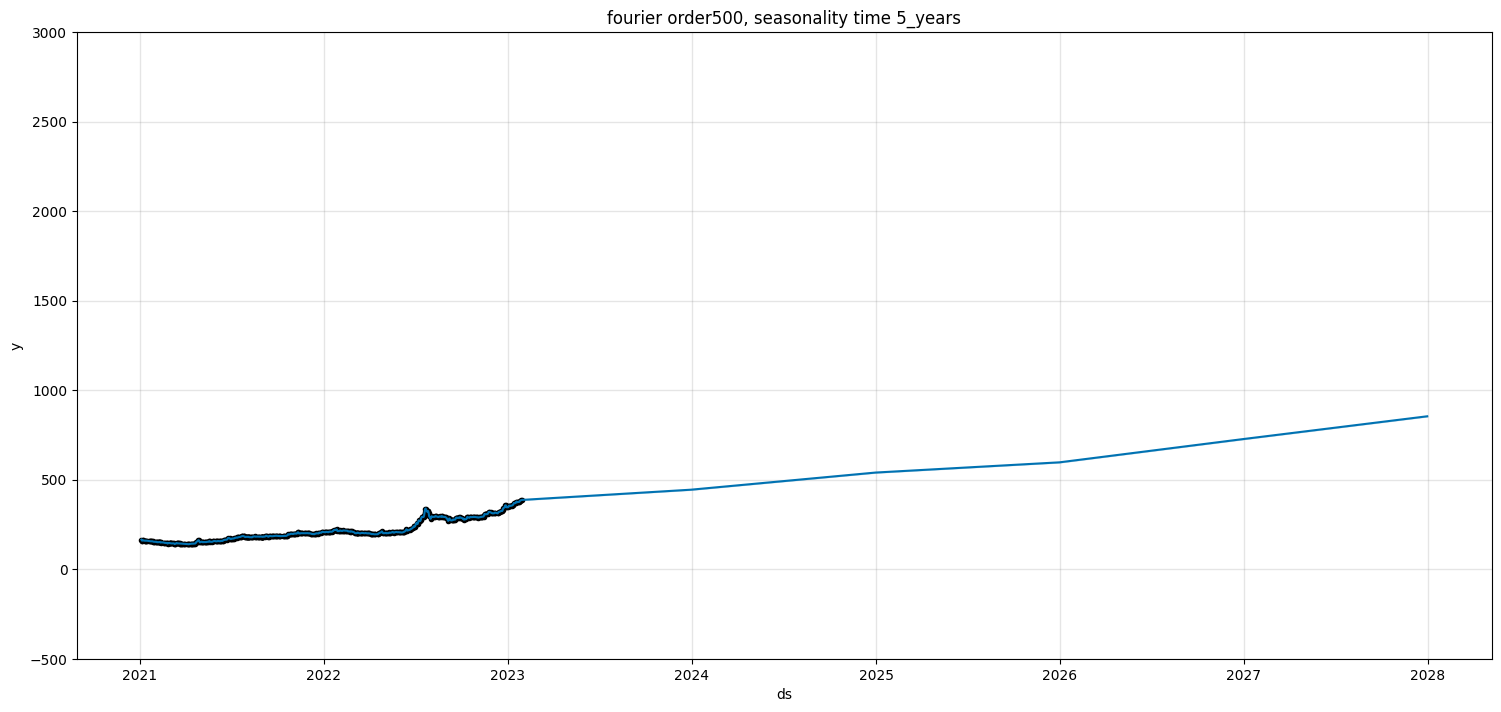

Total Execution Time 20.00539541244507 seconds


In [24]:
training_set = df
validation_set = df

five_years_model = fb_prophet_function(data=training_set, future_years=5, seasonality_name='5_years', seasonality_val=365*5, seasonality_fourier=500,seasonality_mode='additive')

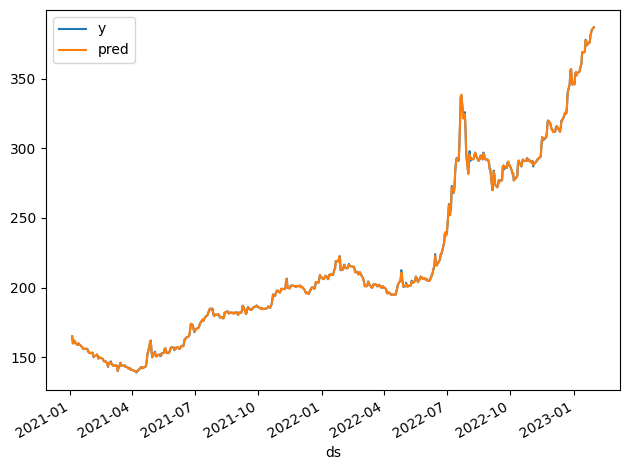

In [25]:
plot_valid(validation_set, 1000, five_years_model)

In [26]:
from prophet.diagnostics import cross_validation, performance_metrics

model = Prophet()
model.fit(df)

df_cv = cross_validation(model, initial='360 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv, rolling_window=0.1) 
 
df_p.head()

22:09:57 - cmdstanpy - INFO - Chain [1] start processing
22:09:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/1 [00:00<?, ?it/s]

22:09:59 - cmdstanpy - INFO - Chain [1] start processing
22:10:00 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days,336.519866,18.344478,15.519204,0.075052,0.066032,0.071262,0.0
1,37 days,376.064899,19.392393,16.650524,0.080697,0.066745,0.076457,0.0
2,38 days,411.653460,20.289245,17.688346,0.085815,0.075636,0.081179,0.0
3,39 days,451.443666,21.247204,18.711385,0.090922,0.077732,0.085838,0.0
4,40 days,495.437739,22.258431,19.770614,0.096249,0.077843,0.090667,0.0


In [27]:
from sklearn.metrics import mean_squared_error
pred = pred[['ds', 'yhat']]

pred
validation_set = validation_set[['ds', 'y']]

validation_set
pred = pred[pred['ds'].isin(validation_set['ds'])]

pred
merged2 = pd.merge(pred, validation_set, on='ds', how='inner')

validation_ds_y = merged2[['ds', 'y']]
pred_ds_yhat = merged2[['ds', 'yhat']]

validation_ds_y['ds'] = validation_ds_y['ds'].apply(lambda x: x.timestamp())
pred_ds_yhat['ds'] = pred_ds_yhat['ds'].apply(lambda x: x.timestamp())
validation_ds_y['ds'] = validation_ds_y['ds'].astype(float)
pred_ds_yhat['ds'] = pred_ds_yhat['ds'].astype(float)
import math

mae2 = mean_absolute_error(validation_ds_y, pred_ds_yhat)
mse2 = mean_squared_error(validation_ds_y, pred_ds_yhat)
rmse2 = math.sqrt(mean_squared_error(validation_ds_y, pred_ds_yhat))

print("Mean Absolute Error: ", mae2)
print("Mean Squared Error: ", mse2)
print("Root Mean Squared Error: ", rmse2)


Mean Absolute Error:  4.688717681973375
Mean Squared Error:  88.6859275367459
Root Mean Squared Error:  9.41732061346251


C:\Users\rodri\AppData\Local\Temp\ipykernel_12876\4273972159.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_ds_y['ds'] = validation_ds_y['ds'].apply(lambda x: x.timestamp())
C:\Users\rodri\AppData\Local\Temp\ipykernel_12876\4273972159.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_ds_yhat['ds'] = pred_ds_yhat['ds'].apply(lambda x: x.timestamp())
C:\Users\rodri\AppData\Local\Temp\ipykernel_12876\4273972159.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [28]:
from prophet import Prophet

five_years_model = Prophet(seasonality_mode='additive', seasonality_prior_scale=1, 
                         yearly_seasonality=True, weekly_seasonality=False, 
                         daily_seasonality=False)


In [29]:
five_years_model.add_seasonality(name='1_years', period=365*1, fourier_order=90)

In [30]:
import datetime

today = datetime.datetime.now()
next_month = today + datetime.timedelta(days=90)
start_date = today.strftime("%Y-%m-%d")
end_date = next_month.strftime("%Y-%m-%d")
date_range = pd.date_range(start_date, end_date)
next_month = pd.DataFrame({"ds": date_range})


In [31]:
five_years_model.fit(training_set)

prediction = five_years_model.predict(next_month)

22:10:04 - cmdstanpy - INFO - Chain [1] start processing
22:10:12 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
values = prediction['yhat']

values_new = pd.DataFrame(values)

values_new = values_new.rename(columns={'yhat':'Values'})

values_new

,Values
0,382.632155
1,383.182988
2,382.931166
3,383.215080
4,384.094318
...,...
86,384.561866
87,385.659133
88,383.519019
89,379.319335


In [33]:
# import the datetime library
import datetime

# define the start date (today + 1) and the number of days in the range
start_date = datetime.datetime.today() + datetime.timedelta(days=1)
num_days = len(values_new.index)

# create the date range
date_range = [start_date.date() + datetime.timedelta(days=i) for i in range(num_days)]

# set the index of the dataframe to the date range
values_new.index = date_range

values_new


,Values
2023-01-31,382.632155
2023-02-01,383.182988
2023-02-02,382.931166
2023-02-03,383.215080
2023-02-04,384.094318
...,...
2023-04-27,384.561866
2023-04-28,385.659133
2023-04-29,383.519019
2023-04-30,379.319335


In [34]:
values_new.to_excel("data/xlsx/values_newBlue.xlsx")

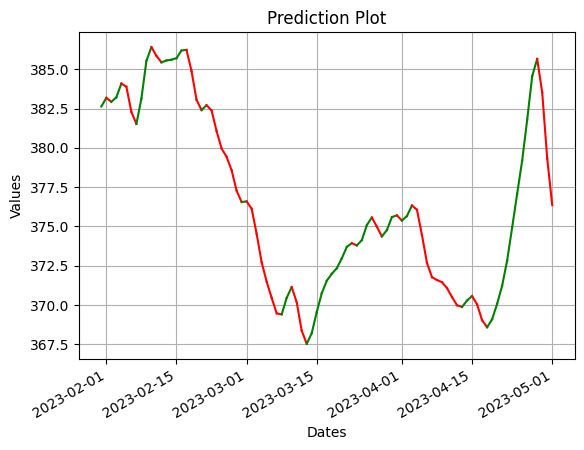

In [35]:
x = values_new.index
y = values_new['Values']
for i in range(1, len(values_new)):
    if y[i] > y[i-1]:
        color = 'g'
    else:
        color = 'r'
    plt.plot(x[i-1:i+1], y[i-1:i+1], color=color)
plt.xlabel("Dates")
plt.ylabel("Values")
plt.title("Prediction Plot")
plt.grid()
plt.gcf().autofmt_xdate()
plt.show()


In [36]:
import plotly.graph_objs as go
import plotly.offline as pyo

data = []
for i in range(1, len(values_new)):
    if y[i] > y[i-1]:
        color = 'green'
    else:
        color = 'red'
    trace = go.Scatter(x=x[i-1:i+1], y=y[i-1:i+1], mode='lines', line=dict(color=color, width=1), showlegend=False)
    data.append(trace)

layout = go.Layout(title='Prediccion Dolar Blue', xaxis=dict(title='Fecha'), yaxis=dict(title='Valores'))
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

In [37]:
with open('data/html/Predicciones/Pred_DolarBlue.html', 'w') as f:
    f.write(fig.to_html(include_plotlyjs='cdn'))